## Graph Transformers for Blood-Brain-Barrier Penetration Prediction
**Ayush Noori**

First, I load the relevant libraries.

In [4]:
# import base libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # inline plots
%matplotlib inline

# import torch
import torch

# import TDC
from tdc.single_pred import ADME
from tdc.chem_utils import MolConvert

### Load and Stratify Data

Next, I load the dataset retrieved from the [Therapeutics Data Commons (TDC)](https://tdcommons.ai/single_pred_tasks/adme/#bbb-blood-brain-barrier-martins-et-al) and examine basic parameters.

Found local copy...
Loading...
Done!
--- Dataset Statistics ---
1975 unique drugs.
--------------------------


Label Distribution:
1    1551
0     479
Name: Y, dtype: int64


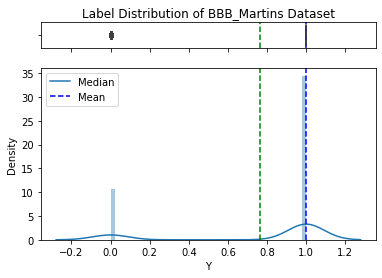

In [5]:
data = ADME(name = 'BBB_Martins')
data.print_stats()
print("Label Distribution:")
print(data.y.value_counts())
data.label_distribution()

Stratify the dataset and examine the test set. Rather than a random split, we use the more challenging ["scaffold split"](https://tdcommons.ai/functions/data_split/), which partitions the data based on the scaffold of the molecules to differentiate the training, validation, and test sets. The data is split as 70% training, 10% validation, and 20% test.

Note that the scaffold split requires that the [`rdkit`](https://www.rdkit.org/docs/GettingStartedInPython.html) package is installed.

In [6]:
split = data.get_split(method = 'scaffold', seed = 42, frac = [0.7, 0.1, 0.2])
split['test']

100%|██████████| 2030/2030 [00:00<00:00, 2582.12it/s]


,Drug_ID,Drug,Y
0,tetrazepam,CN1C(=O)CN=C(C2=CCCCC2)c2cc(Cl)ccc21,1
1,menitrazepam,CN1C(=O)CN=C(C2=CCCCC2)c2cc([N+](=O)[O-])ccc21,1
2,nortetrazepam,O=C1CN=C(C2=CCCCC2)c2cc(Cl)ccc2N1,1
3,Oxacillin,Cc1onc(-c2ccccc2)c1C(=O)N[C@@H]1C(=O)N2[C@@H](...,0
4,Flucloxacillin,Cc1onc(-c2c(F)cccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[C...,0
...,...,...,...
401,arecoline,COC(=O)C1=CCCN(C)C1,1
402,penfluridol,OC1(c2ccc(Cl)c(C(F)(F)F)c2)CCN(CCCC(c2ccc(F)cc...,1
403,Org12692,FC(F)(F)c1ccc(N2CCNCC2)nc1Cl,1
404,Org12962,FC(F)(F)c1ccc(N2CCNCC2)nc1Cl,1


### Convert from SMILES to DGL

Now, define a converter to convert molecules from SMILES structures to [DGL](https://docs.dgl.ai/index.html) format. See documentation [here](https://tdcommons.ai/functions/data_process/#molecule-conversion). For example, try:
```
converter('Clc1ccccc1C2C(=C(/N/C(=C2/C(=O)OCC)COCCN)C)\C(=O)OC')
```

In [7]:
converter = MolConvert(src = 'SMILES', dst = 'DGL')
converted_mol = converter(split['train']['Drug'][0])
converted_mol

Graph(num_nodes=23, num_edges=46,
      ndata_schemes={}
      edata_schemes={})

### Generate Graphormer Customized Dataset

Reassemble the stratified dataset into a single data frame with train/validation/test indices.

In [8]:
split_data = split['train'].append(split['valid']).append(split['test'])
train_idx = np.arange(len(split['train']))
valid_idx = np.arange(len(split['valid'])) + len(split['train'])
test_idx = np.arange(len(split['test'])) + len(split['train']) + len(split['valid'])

Compare the original stratification and subsetted final dataset to confirm they are identical.

In [9]:
split['train']

,Drug_ID,Drug,Y
0,Terbutylchlorambucil,CC(C)(C)OC(=O)CCCc1ccc(N(CCCl)CCCl)cc1,1
1,brosotamide,Cc1cc(Br)cc(C(N)=O)c1O,1
2,butacetin,CC(=O)Nc1ccc(OC(C)(C)C)cc1,1
3,Salicyluricacid,O=C(O)CNC(=O)c1ccccc1O,1
4,sumacetamol,CSCC[C@H](NC(C)=O)C(=O)Oc1ccc(NC(C)=O)cc1,1
...,...,...,...
1416,antipyrine,Cc1cc(=O)n(-c2ccccc2)n1C,1
1417,Aminopyrine,Cc1c(N(C)C)c(=O)n(-c2ccccc2)n1C,1
1418,cyprazepam,ON1CC(=NCC2CC2)N=c2ccc(Cl)cc2=C1c1ccccc1,1
1419,nomifensine,CN1Cc2c(N)cccc2C(c2ccccc2)C1,1


In [10]:
split_data.iloc[train_idx]

,Drug_ID,Drug,Y
0,Terbutylchlorambucil,CC(C)(C)OC(=O)CCCc1ccc(N(CCCl)CCCl)cc1,1
1,brosotamide,Cc1cc(Br)cc(C(N)=O)c1O,1
2,butacetin,CC(=O)Nc1ccc(OC(C)(C)C)cc1,1
3,Salicyluricacid,O=C(O)CNC(=O)c1ccccc1O,1
4,sumacetamol,CSCC[C@H](NC(C)=O)C(=O)Oc1ccc(NC(C)=O)cc1,1
...,...,...,...
1416,antipyrine,Cc1cc(=O)n(-c2ccccc2)n1C,1
1417,Aminopyrine,Cc1c(N(C)C)c(=O)n(-c2ccccc2)n1C,1
1418,cyprazepam,ON1CC(=NCC2CC2)N=c2ccc(Cl)cc2=C1c1ccccc1,1
1419,nomifensine,CN1Cc2c(N)cccc2C(c2ccccc2)C1,1


Convert the subsetted final dataset into a list of tuples compatible with Graphormer.

In [11]:
dataset = [(converter(x), torch.tensor([y])) for x, y in zip(split_data['Drug'], split_data['Y'])]
dataset[0]

(Graph(num_nodes=23, num_edges=46,
       ndata_schemes={}
       edata_schemes={}),
 tensor([1]))

### Check QM9 Dataset

Following the [Graphormer documentation](https://graphormer.readthedocs.io/en/latest/Datasets.html#id5), confirm that the output structure of `dataset` matches that of the [QM9 dataset](https://docs.dgl.ai/en/latest/_modules/dgl/data/qm9.html).

In [12]:
from dgl.data import QM9
from sklearn.model_selection import train_test_split

qm9_dataset = QM9(label_keys=["mu"])
num_graphs_qm9 = len(qm9_dataset)

# customized dataset split
train_valid_idx, test_idx = train_test_split(
    np.arange(num_graphs_qm9), test_size=num_graphs_qm9 // 10, random_state=0
)
train_idx, valid_idx = train_test_split(
    train_valid_idx, test_size=num_graphs_qm9 // 5, random_state=0
)

Check the type of the output. The output customized dataset should be a list of tuples, where first element of each tuple is the molecular graph and the second element is the label.

In [13]:
# check type
print("First Element: ", type(qm9_dataset[0][0]))
print("Second Element: ", type(qm9_dataset[0][1]))

First Element:  <class 'dgl.heterograph.DGLHeteroGraph'>
Second Element:  <class 'torch.Tensor'>


In [14]:
# show graph
qm9_dataset[0][0]

Graph(num_nodes=5, num_edges=20,
      ndata_schemes={'R': Scheme(shape=(3,), dtype=torch.float32), 'Z': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={})

In [15]:
qm9_dataset[0]

(Graph(num_nodes=5, num_edges=20,
       ndata_schemes={'R': Scheme(shape=(3,), dtype=torch.float32), 'Z': Scheme(shape=(), dtype=torch.int64)}
       edata_schemes={}),
 tensor([0.]))

### Visualize Molecular Graphs

Based on [this StackOverflow post](https://stackoverflow.com/questions/69308451/how-to-visualize-a-graph-from-dgls-datasets), visualize the graphs of select molecules in either the BBB Martins et al. dataset or the QM9 dataset.

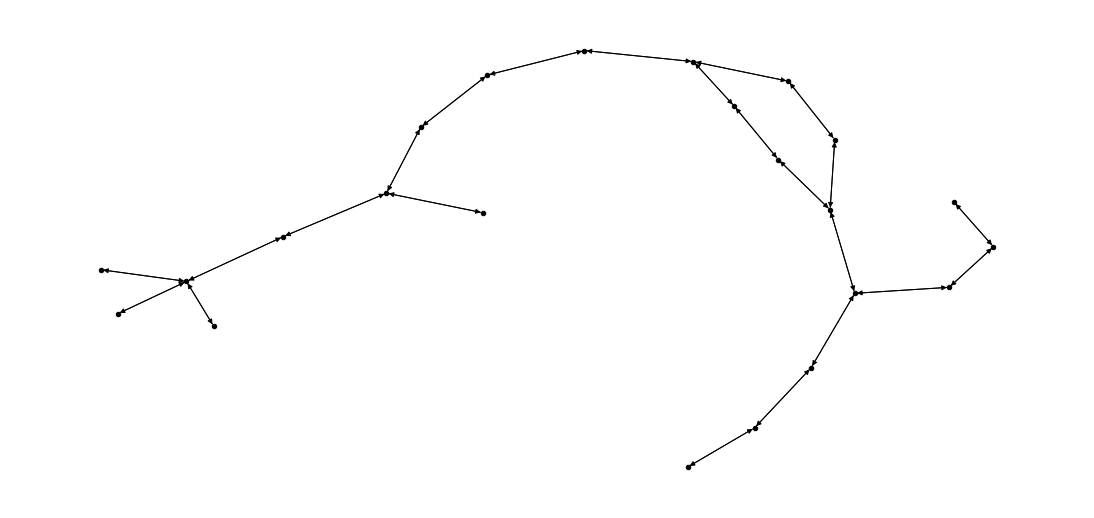

In [19]:
# import libraries
import networkx as nx
from dgl import to_networkx

# for BBB dataset
g = converter(split['train']['Drug'][0])

# for QM9 dataset
# g = qm9_dataset[0][0]

# define options
options = {
    'node_color': 'black',
    'node_size': 20,
    'width': 1,
}

# plot figure
G = to_networkx(g)
plt.figure(figsize=[15,7])
nx.draw(G, **options)